In [1]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
import csv
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy


# 2D UNBIASED Double Well Potential

## 1) The Model

Here we model the double well potential as a quartic function along x  and a parabola along y $V(x,y)= a(x^2-1)^2 + \frac{1}{2}by^2$
and constant diffusion matrix $D= d\begin{bmatrix} 1 \ \ 0 \\\ 0 \ \ 1 \end{bmatrix}$

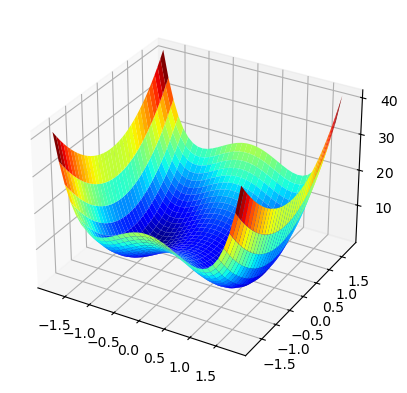

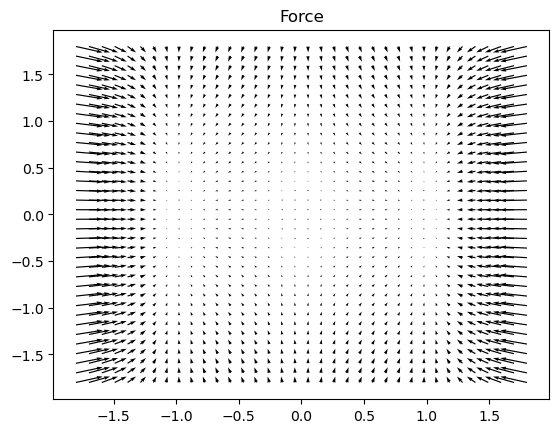

In [5]:
x = np.linspace(-1.8,1.8,36)
y = np.linspace(-1.8,1.8,36)
input=np.transpose(np.array([x,y]))

diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]) * np.eye(2,2))
a,b = 5.0, 10.0
quartic2d= fl.functions.Quartic2D(a=a,b=b)
exx = fl.functions.analytical.My_Quartic2D(a=a,b=b)

X,Y =np.meshgrid(x,y)

# Plot potential surface 
pot = exx.potential(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,pot, rstride=1, cstride=1,cmap='jet', edgecolor = 'none')

# Plot Force function
ff=quartic2d.force(input) # returns x and y components of the force : x_comp =ff[:,0] , y_comp =ff[:,1]
U,V = np.meshgrid(ff[:,0],ff[:,1])
fig, ax =plt.subplots()
ax.quiver(x,y,U,V)
ax.set_title('Force')
# plt.show()
print(quartic2d.domain)
fff=fl.functions.Quartic2DForce(exx.force, dim=2)

## 2) Simulation

In [6]:
dt = 1e-3
model_simu=fl.models.overdamped.Overdamped(force=quartic2d,diffusion=diff_function)
simulator=fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)


In [7]:
# initialize positions 
ntraj=50
q0= np.empty(shape=[ntraj,2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j]=0.0000
time_steps=5000
data_2d_unbias = simulator.run(time_steps, q0,save_every=1)  

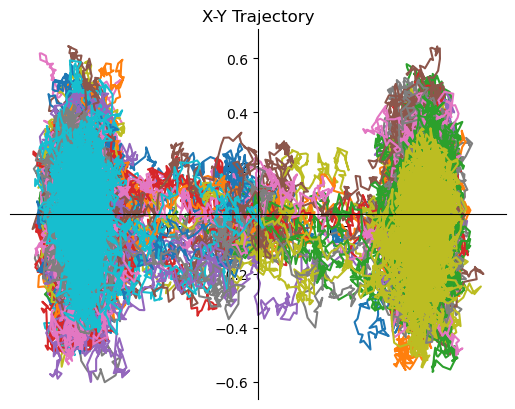

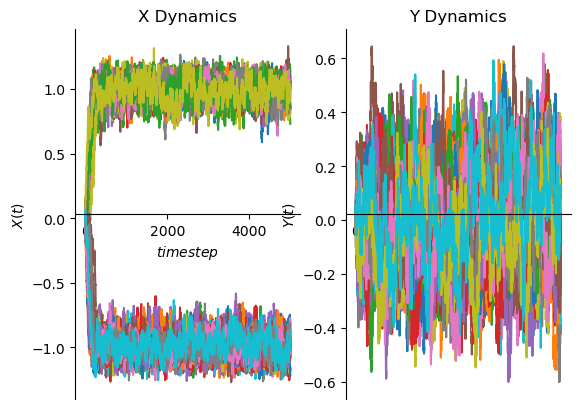

In [8]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data_2d_unbias):
    axs.plot(trj["x"][:,0],trj["x"][:,1])
    axs.spines['left'].set_position('center')
    axs.spines['right'].set_color('none')
    axs.spines['bottom'].set_position('center')
    axs.spines['top'].set_color('none')
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

"""fig, axs = plt.subplots(1,2)
for n, trj in enumerate(data_2d_unbias):
    axs[0].plot(trj["x"][:,0],trj["x"][:,1])
    #axs[1].plot(xmax[:, n])
    axs[1].set_xlabel("$timestep$")
    axs[1].set_ylabel("$x(t)$")
    axs[1].grid()"""
# plot x,y Trajectories in separate subplots
fig,bb =  plt.subplots(1,2)
for n, trj in enumerate(data_2d_unbias):
    bb[0].plot(trj["x"][:,0])
    bb[1].plot(trj["x"][:,1])

# Set visible  axis
    bb[0].spines['right'].set_color('none')
    bb[0].spines['bottom'].set_position('center')
    bb[0].spines['top'].set_color('none')
    bb[0].xaxis.set_ticks_position('bottom')
    bb[0].yaxis.set_ticks_position('left')
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")

# Set visible axis
    bb[1].spines['right'].set_color('none')
    bb[1].spines['bottom'].set_position('center')
    bb[1].spines['top'].set_color('none')
    bb[1].xaxis.set_ticks_position('bottom')
    bb[1].yaxis.set_ticks_position('left')
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")

    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")

## 2.1) Simulation 1D with same coefficients

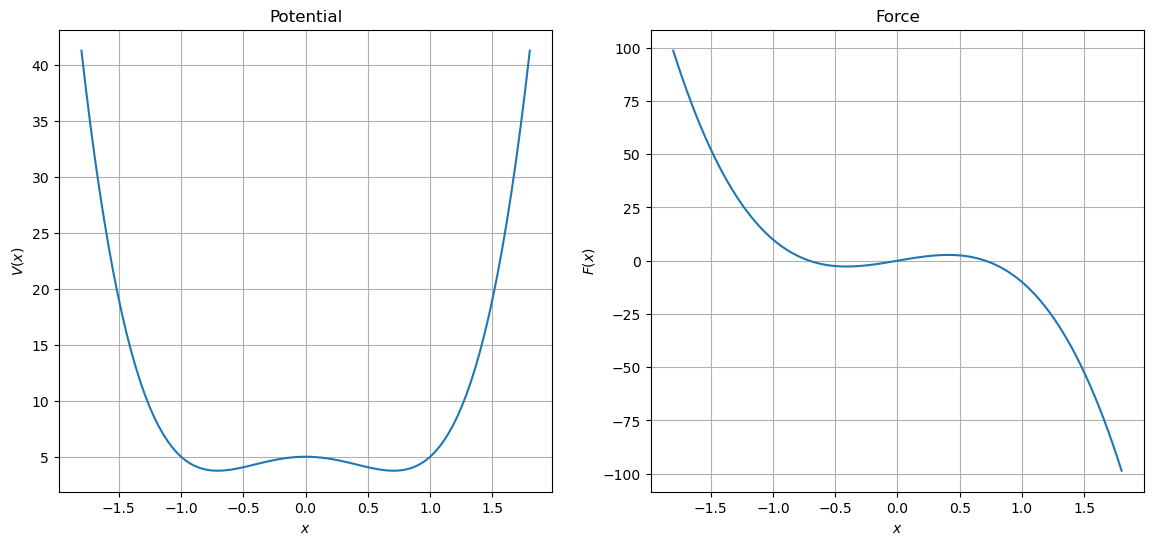

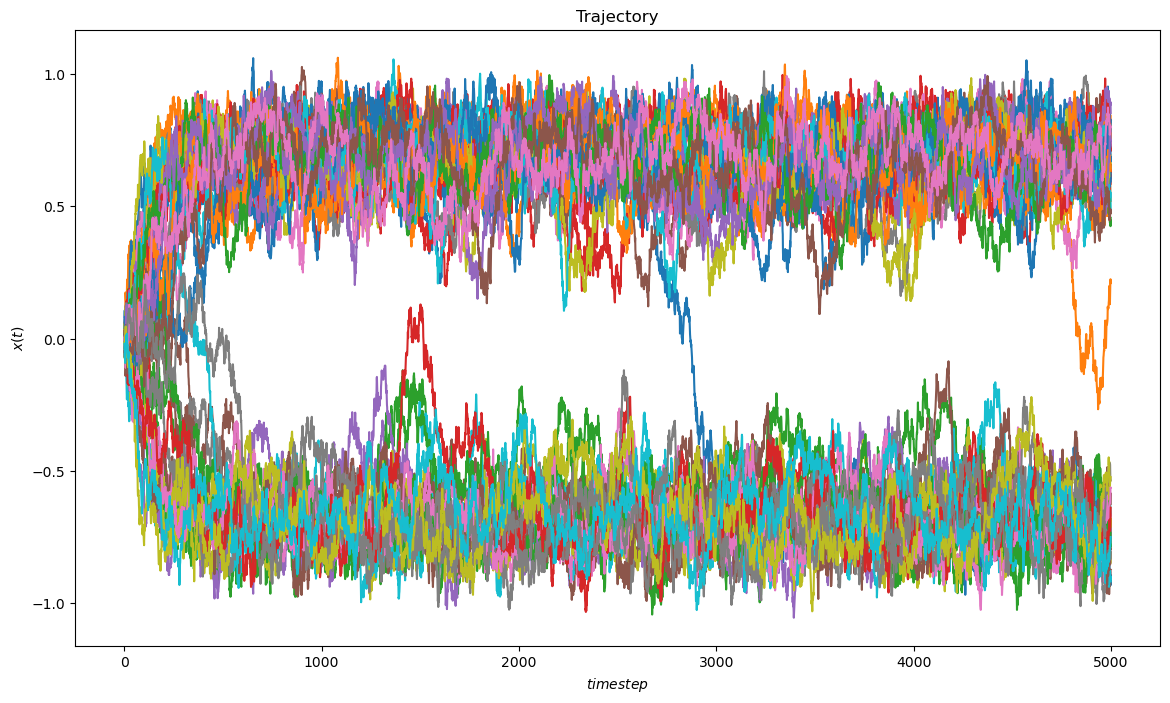

In [9]:
coeff=a*np.array([1,0,-1,0,1])
free_energy = np.polynomial.Polynomial(coeff)
# diff_coeff = np.polynomial.Polynomial(np.array([]))
force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]])
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

# Plot of Free Energy and Force
x_values = np.linspace(-1.8, 1.8, 100)
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

# Define model to simulate and type of simulator to use
dt=1e-3
model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt) #, k=0.0, xstop=6.0)


# initialize positions 
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0.0
# Calculate Trajectory, n_traj and timesteps is the same as that of the 2D simulation
data_1D_unbias = simulator.run(time_steps, q0, 1)

fig, axs = plt.subplots(figsize=(14,8))
for n, trj in enumerate(data_1D_unbias):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")
    # axs[1].plot(xmax[:, n])
    axs.set_xlabel("$timestep$")
    axs.set_ylabel("$x(t)$")
    axs.grid()

## 3) Fitting 

### 3.1) Projecting onto the x Coordinate 


In [10]:
xdata = fl.data.trajectories.Trajectories(dt=dt) 
s = np.empty(shape=(len(trj["x"][:,0]),1))
for n, trj in enumerate(data_2d_unbias):
    for j in range(len(trj["x"][:,0])):
        s[j]=trj["x"][:,0][j]
    xdata.append(s)
print(len(s))
# #### Possible models 
# trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
# traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
# trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)
xfa = np.linspace(-1.3, 1.3, 75)
xforce = -4*a*(xfa** 3 - xfa)

5000


#### 3.1.1) Fitting with exact model

Euler [ -3.67749087  12.63081002  -2.23860908 -18.95903083   0.50153515]
Elerian [ -3.67749087  12.63081002  -2.23860908 -18.95903083   0.50153515]
Kessler [ -3.67748409  12.63080407  -2.23860855 -18.95902518   0.52057918]
Drozdov [ -3.6774904   12.63081049  -2.23861633 -18.95901594   0.52099348]


Text(0.5, 0.98, 'Order 3 Polynomial fitting along x direction')

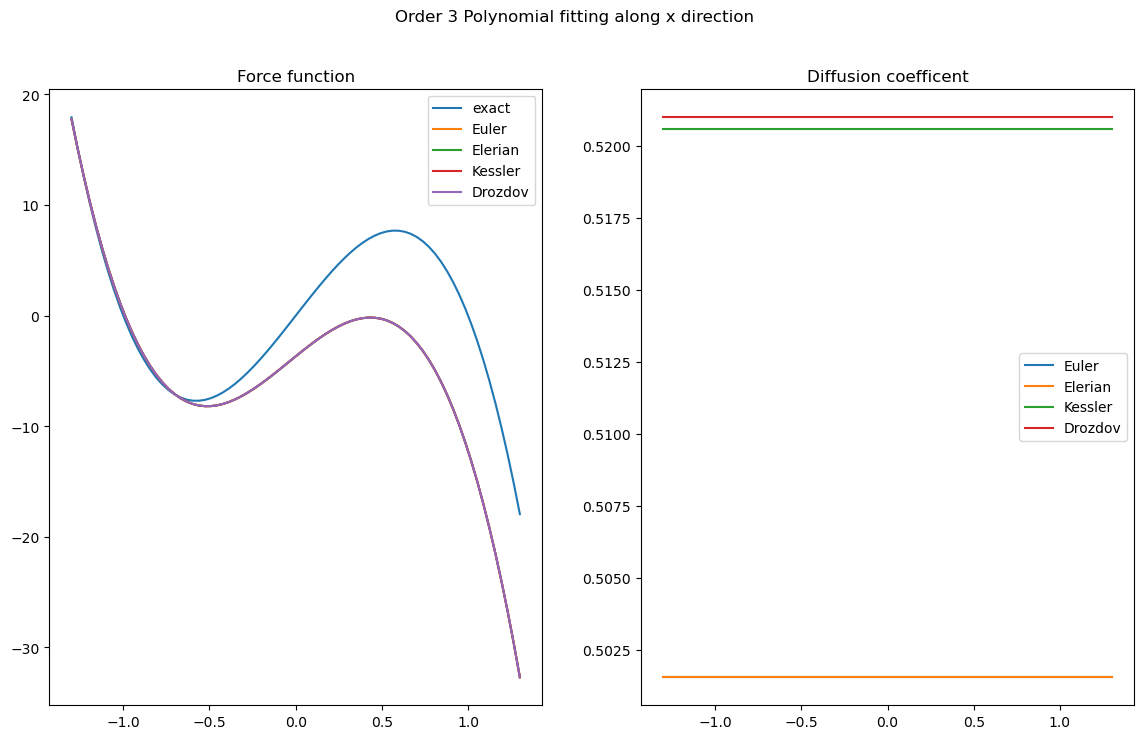

In [16]:
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx))) # and when the second estimator uses the object trainmodel this will already have the modfications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx))) # made by the previuos estimatorand so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx))) # which is the reason why the loop checking if the values are different in the following cell exists


Eul_res=Eul_estimator.fit_fetch(deepcopy(xdata))
Eln_res=Eln_estimator.fit_fetch(deepcopy(xdata))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(xdata))
Drz_res=Drz_estimator.fit_fetch(deepcopy(xdata))
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion coefficent')
ax[0].legend()
ax[1].legend()
fig.suptitle('Order 3 Polynomial fitting along x direction')


fitting of the 1D data 


Euler [ 1.07708820e-02  1.00453324e+01  1.42341744e-01 -2.00119683e+01
  4.98698347e-01]
Elerian [ 1.07708820e-02  1.00453324e+01  1.42341744e-01 -2.00119683e+01
  4.98698347e-01]
Kessler [ 1.07709704e-02  1.00453340e+01  1.42342053e-01 -2.00119654e+01
  5.07272165e-01]
Drozdov [ 1.07708820e-02  1.00453347e+01  1.42341898e-01 -2.00119647e+01
  5.07379549e-01]


Text(0.5, 0.98, 'Order 3 Polynomial fitting of 1D data')

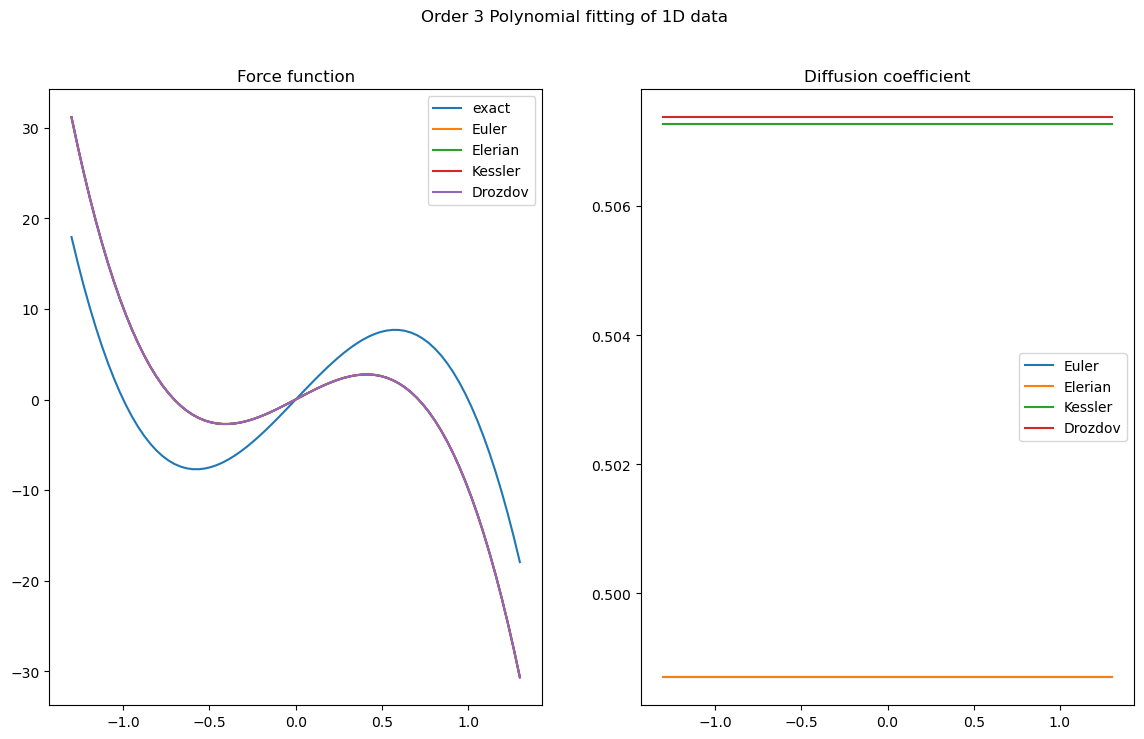

In [15]:
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx))) # and when the second estimator uses the object trainmodel this will already have the modfications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx))) # made by the previuos estimatorand so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx))) # which is the reason why the loop checking if the values are different in the following cell exists


Eul_res=Eul_estimator.fit_fetch(deepcopy(data_1D_unbias))
Eln_res=Eln_estimator.fit_fetch(deepcopy(data_1D_unbias))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(data_1D_unbias))
Drz_res=Drz_estimator.fit_fetch(deepcopy(data_1D_unbias))
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion coefficient')
ax[0].legend()
ax[1].legend()
fig.suptitle('Order 3 Polynomial fitting of 1D data')

#### 3.1.2) Fitting with B-splines

Training with 4-knots B-splines

/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Text(0.5, 0.98, 'B-spline Fitting with 4 knots')

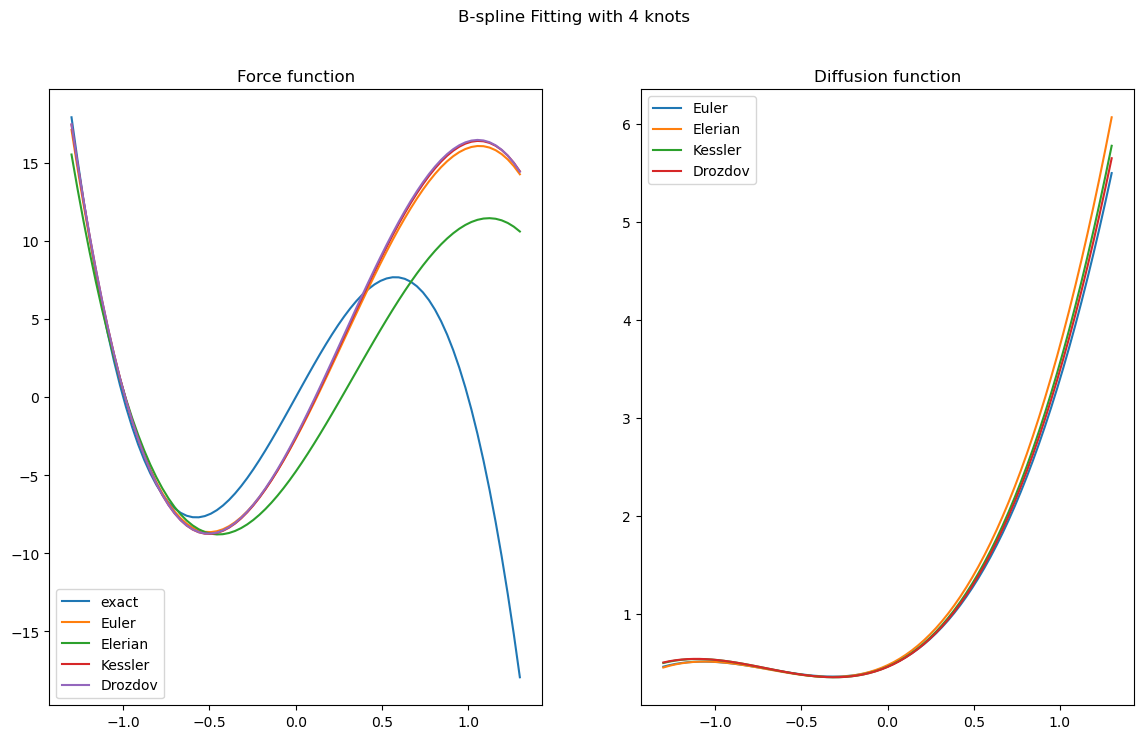

In [17]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(deepcopy(xdata))
Eln_res=Eln_estimator.fit_fetch(deepcopy(xdata))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(xdata))
Drz_res=Drz_estimator.fit_fetch(deepcopy(xdata))

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')



fitting of the 1D data

Text(0.5, 0.98, 'B-spline Fitting with 4 knots')

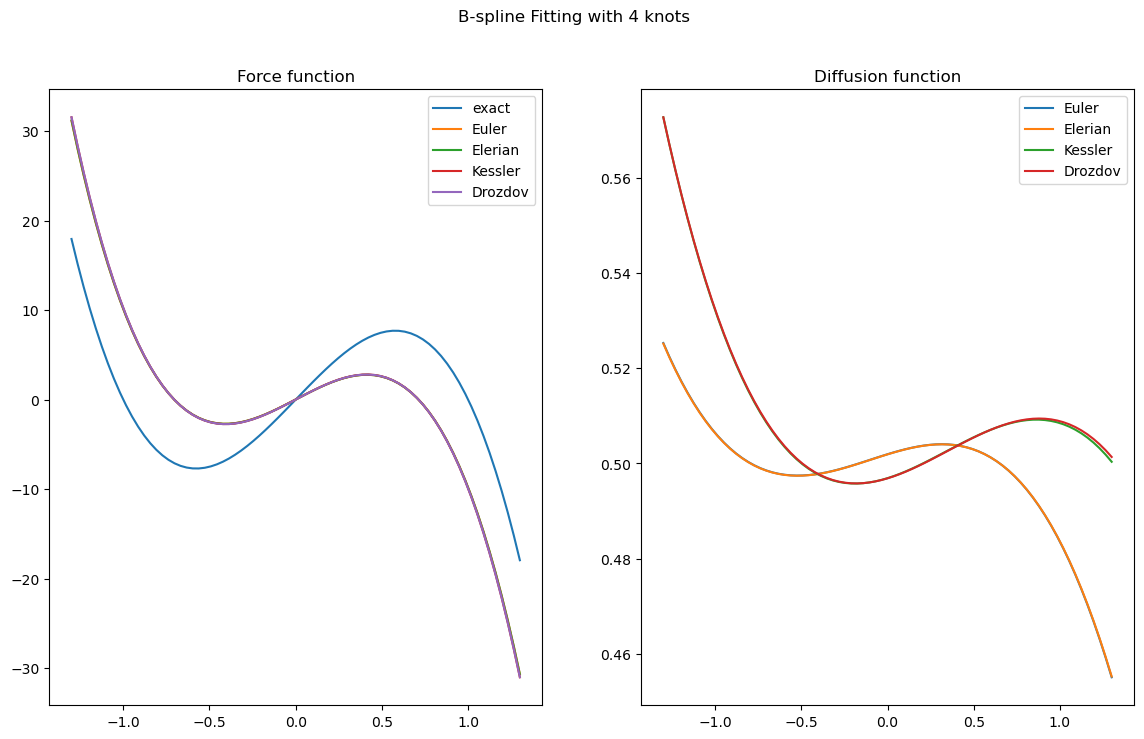

In [18]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(deepcopy(data_1D_unbias))
Eln_res=Eln_estimator.fit_fetch(deepcopy(data_1D_unbias))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(data_1D_unbias))
Drz_res=Drz_estimator.fit_fetch(deepcopy(data_1D_unbias))

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')


### 3.2) Projection onto y coordinate

In [ ]:
ydata = fl.data.trajectories.Trajectories(dt=dt) 
s = np.empty(shape=(len(trj["x"][:,1]),1))
for n, trj in enumerate(data_2d_unbias):
    for j in range(len(trj["x"][:,1])):
        s[j]=trj["x"][:,1][j]
    ydata.append(s)
print(len(s))
# #### Possible models 
# trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
# traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
# trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)
yfa = np.linspace(-1.3, 1.3, 75)
yforce= -b*yfa

5000


#### 3.2.1) Fitting with exact  Ornstein–Uhlenbeck model

Text(0.5, 0.98, ' Ornstein–Uhlenbeck Fitting along y direction')

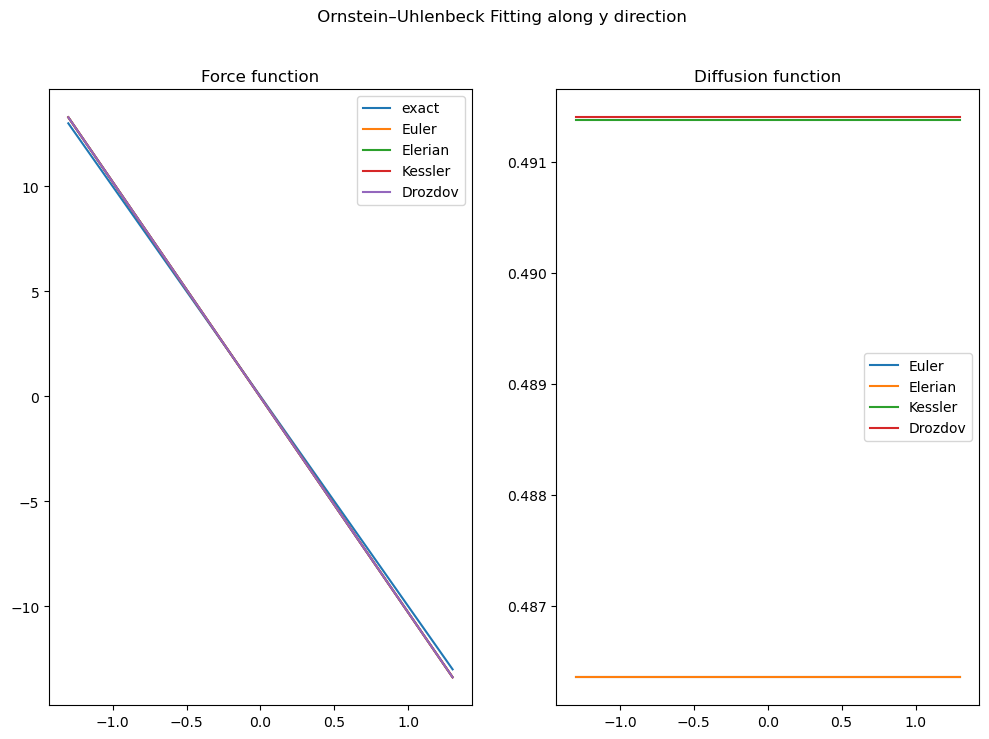

In [ ]:
trainmodel=fl.models.OrnsteinUhlenbeck(has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel))) # and when the second estimator uses the object trainmodel this will already have the modfications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimatorand so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists


Eul_res=Eul_estimator.fit_fetch(deepcopy(ydata))
Eln_res=Eln_estimator.fit_fetch(deepcopy(ydata))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(ydata))
Drz_res=Drz_estimator.fit_fetch(deepcopy(ydata))

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(yfa, yforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(yfa, res.force(yfa.reshape(-1, 1)), label=name)
    ax[1].plot(yfa, res.diffusion(yfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('Ornstein–Uhlenbeck Fitting along y direction')

In [ ]:
for res in res_vec:
    print(res.coefficients)

[ -0.04527936 -10.25563774   0.48636073]
[ -0.04527936 -10.25563774   0.48636073]
[ -0.04527947 -10.25563669   0.4913739 ]
[ -0.04527936 -10.25563642   0.49140078]


### 3.3) Projecting onto $1^{st}$ and $3^{rd}$ quadrant bisectrix

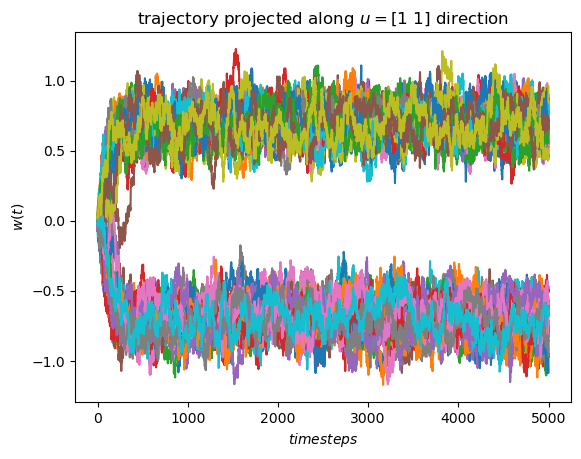

In [ ]:
u = np.array([1,1])
u_norm= (1/np.linalg.norm(u,2))*u
w = np.empty(shape=(len(trj["x"]),1))

proj_data = fl.data.trajectories.Trajectories(dt=dt) # create new Trajectory object in which to store the projected trajectory dictionaries

fig, axs =plt.subplots()
for n, trj in enumerate(data_2d_unbias):
    for i in range(len(trj["x"])):
        w[i]=np.dot(trj["x"][i],u_norm)
    proj_data.append(w)
    axs.plot(proj_data[n]["x"])
    axs.set_xlabel("$timesteps$")
    axs.set_ylabel("$w(t)$")
    axs.set_title("trajectory projected along $u =$"  + str(u) + " direction")
    axs.grid()

#### 3.3.1) Fitting with splines

Text(0.5, 0.98, 'B-spline Fitting with 4 knots')

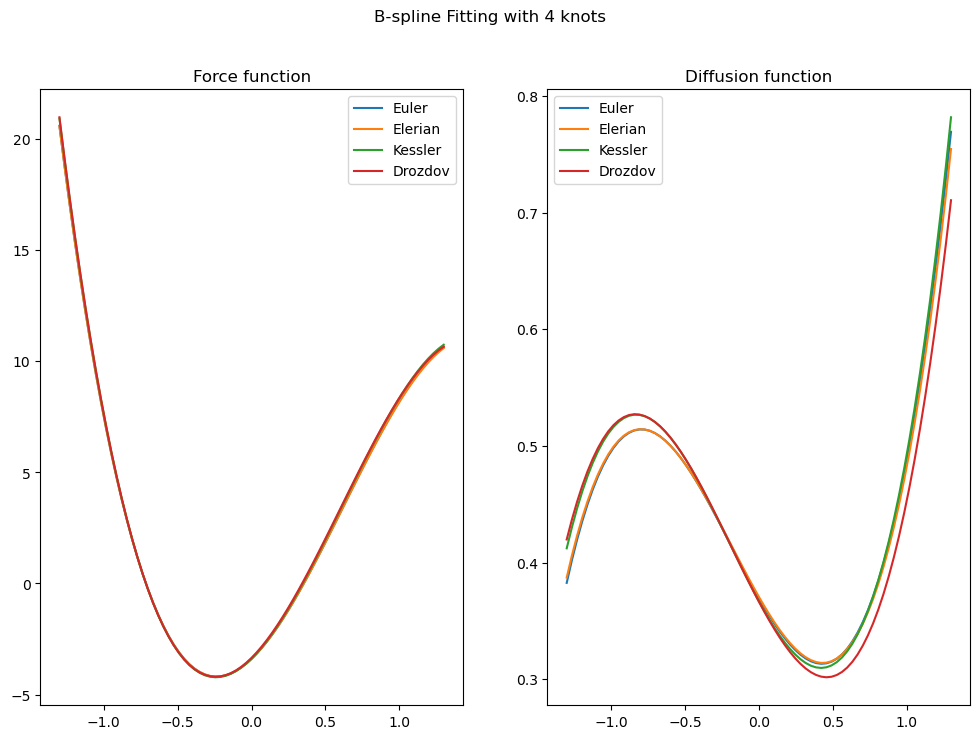

In [ ]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(deepcopy(proj_data))
Eln_res=Eln_estimator.fit_fetch(deepcopy(proj_data))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(proj_data))
Drz_res=Drz_estimator.fit_fetch(deepcopy(proj_data))

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')


n_knots=15
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(proj_data)
Eln_res=Eln_estimator.fit_fetch(proj_data)
Ksl_res=Ksl_estimator.fit_fetch(proj_data)
Drz_res=Drz_estimator.fit_fetch(proj_data)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

     # PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')

n_knots=20
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(proj_data)
Eln_res=Eln_estimator.fit_fetch(proj_data)
Ksl_res=Ksl_estimator.fit_fetch(proj_data)
Drz_res=Drz_estimator.fit_fetch(proj_data)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

         # PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')

# 2D BIASED Double Well Potential

## 1) Model 

Here we model the double well potential as a quartic function along x and a parabola along y $V(x,y)= a(x^2-1)^2 + \frac{1}{2}by^2$
and constant diffusion matrix $D= d\begin{bmatrix} 1 \ \ 0 \\\ 0 \ \ 1 \end{bmatrix} $ 


Text(0.5, 1.0, 'Force')

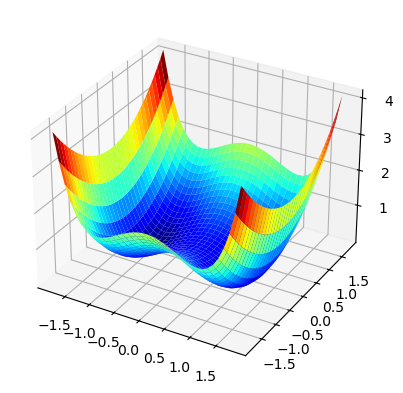

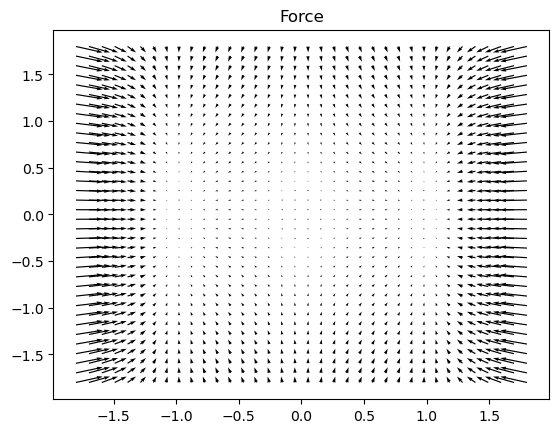

In [ ]:
x = np.linspace(-1.8,1.8,36)
y = np.linspace(-1.8,1.8,36)
input=np.transpose(np.array([x,y]))

diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]) * np.eye(2,2))
a,b = 0.5, 1.0
quartic2d= fl.functions.Quartic2D(a=a,b=b)
exx = fl.functions.analytical.My_Quartic2D(a=a,b=b)

X,Y =np.meshgrid(x,y)

# Plot potential surface 
pot = exx.potential(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,pot, rstride=1, cstride=1,cmap='jet', edgecolor = 'none')

# Plot Force function
ff=quartic2d.force(input) # returns x and y components of the force : x_comp =ff[:,0] , y_comp =ff[:,1]
U,V = np.meshgrid(ff[:,0],ff[:,1])
fig, ax =plt.subplots()
ax.quiver(x,y,U,V)
ax.set_title('Force')

# print(quartic2d.domain)
# fff=fl.functions.Quartic2DForce(exx.force, dim=2)


On top of that we apply a linear bias along the chosen collective variable $q(x,y)= x+y$ feeding the biased 1DColval simulator class the collective variable as  function and its gradient

## 2) Simulation

In [ ]:
def colvar (x,y):
    return x+y

grad_colvar=np.array([1,1])
dt = 1e-3
model_simu=fl.models.overdamped.Overdamped(force=quartic2d,diffusion=diff_function)
simulator=fl.simulations.ABMD_2D_to_1DColvar_Simulator(fl.simulations.EulerStepper(model_simu), dt,colvar=colvar,grad_colvar=grad_colvar,k=7.0,qstop=1.5)


In [ ]:
# initialize positions 
ntraj=50
q0= np.empty(shape=[ntraj,2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j]=-1.2
time_steps=15000
data_2d_bias = simulator.run(time_steps, q0,save_every=1)  

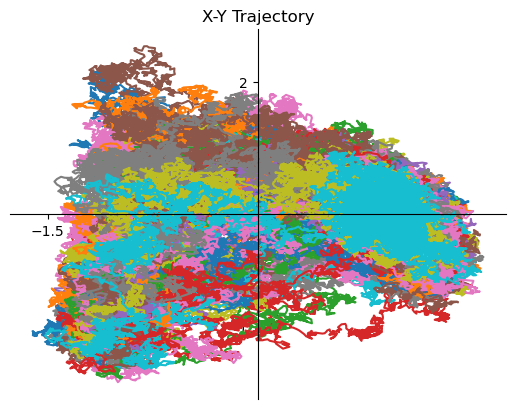

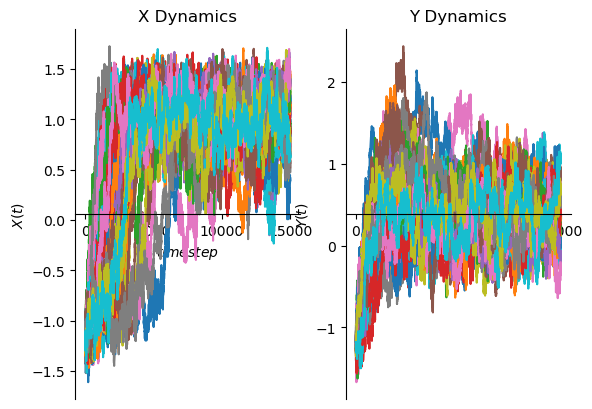

In [ ]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data_2d_bias):
    axs.plot(trj["x"][:,0],trj["x"][:,1])
    axs.spines['left'].set_position('center')
    axs.spines['right'].set_color('none')
    axs.spines['bottom'].set_position('center')
    axs.spines['top'].set_color('none')
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

"""fig, axs = plt.subplots(1,2)
for n, trj in enumerate(data_2d_bias):
    axs[0].plot(trj["x"][:,0],trj["x"][:,1])
    #axs[1].plot(xmax[:, n])
    axs[1].set_xlabel("$timestep$")
    axs[1].set_ylabel("$x(t)$")
    axs[1].grid()"""
# plot x,y Trajectories in separate subplots
fig,bb =  plt.subplots(1,2)
for n, trj in enumerate(data_2d_bias):
    bb[0].plot(trj["x"][:,0])
    bb[1].plot(trj["x"][:,1])

# Set visible  axis
    bb[0].spines['right'].set_color('none')
    bb[0].spines['bottom'].set_position('center')
    bb[0].spines['top'].set_color('none')
    bb[0].xaxis.set_ticks_position('bottom')
    bb[0].yaxis.set_ticks_position('left')
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")

# Set visible axis
    bb[1].spines['right'].set_color('none')
    bb[1].spines['bottom'].set_position('center')
    bb[1].spines['top'].set_color('none')
    bb[1].xaxis.set_ticks_position('bottom')
    bb[1].yaxis.set_ticks_position('left')
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")

    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")

## 3) Fitting

### 3.1) Projecting onto the x Coordinate 


In [ ]:
xdata = fl.data.trajectories.Trajectories(dt=dt) 
s = np.empty(shape=(len(trj["x"][:,0]),1))
for n, trj in enumerate(data_2d_bias):
    # del trj["xt"]
    xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0].reshape(len(trj["x"][:,0]),1), bias=trj["bias"][:,:1].reshape(len(trj["bias"][:,1]),1)))
    # for j in range(len(trj["x"][:,0])):
        # xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0], bias=trj["bias"][:,0]))
        # s[j]=trj["x"][:,0][j]
    # xdata.append(s,bias=trj["bias"][:,0])
    # xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0], bias=trj["bias"][:,0,1]))


# print(len(s))
# #### Possible models 
# trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
# traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
# trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)
xfa = np.linspace(-1.3, 1.3, 75)
xforce = -4*a*(xfa** 3 - xfa)

In [ ]:
xdata[15]["x"].shape

(15000, 1)

#### 3.1.1) Fitting with exact model

Model is not biased
Euler [ 20.59567489 -25.78129601   6.31681686  10.64017076   0.38257953
   0.88306936  -0.28142533   0.76925103]
Model is not biased
Elerian [ 20.58149862 -25.76461086   6.3176004   10.59115622   0.38714988
   0.87363444  -0.26572702   0.75451297]
Model is not biased
Kessler [ 20.92718618 -26.28181093   6.69217498  10.74270101   0.41218712
   0.87768902  -0.29741976   0.78168526]
Model is not biased
Drozdov [ 20.97827123 -26.40461244   6.93545933  10.65324387   0.4197883
   0.85994488  -0.2593506    0.7105789 ]
KM[0.         0.         0.         0.         0.50036386]


Text(0.5, 0.98, 'WARNING : THEY ALL HAVE THE SAME COEFFICIENTS \n Order 3 Polynomial fitting along x direction ')

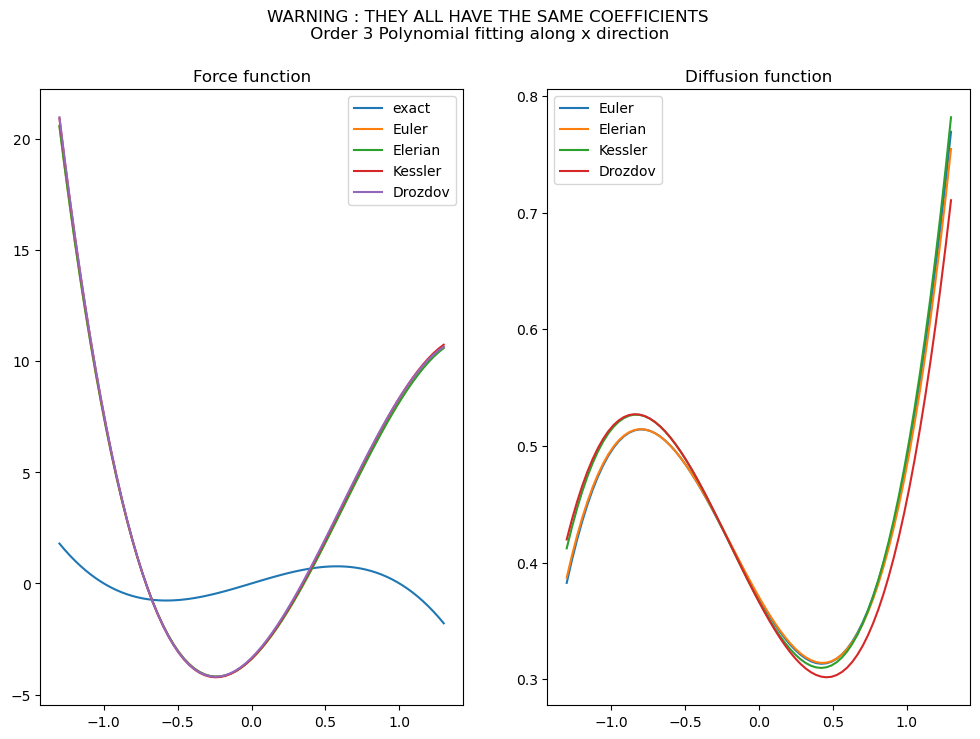

In [ ]:

# trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
# traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
# Eul_biased_trainmodelx = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)
# Eln_biased_trainmodelx = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)
# Ksl_biased_trainmodelx = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)
# Drz_biased_trainmodelx = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)
# KMmodel = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)

# Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity((Eul_biased_trainmodelx)))   # deepcopy is used because the estimator modifies the model when fit method is called
# Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity((Eln_biased_trainmodelx))) # and when the second estimator uses the object trainmodel this will already have the modfications
# Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity((Ksl_biased_trainmodelx))) # made by the previuos estimatorand so in the end they will return the exact same results
# Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity((Drz_biased_trainmodelx))) # which is the reason why the loop checking if the values are different in the following cell exists

# res_KM = fl.KramersMoyalEstimator(KMmodel).fit_fetch(xdata)
# Eul_res=Eul_estimator.fit_fetch(xdata)
# Eln_res=Eln_estimator.fit_fetch(xdata)
# Ksl_res=Ksl_estimator.fit_fetch(xdata)
# Drz_res=Drz_estimator.fit_fetch(xdata)
# res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
# axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
# axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
ax[0].plot(xfa, xforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,):
    res.remove_bias()
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)
print('KM'+str(res_KM.coefficients))
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('WARNING : THEY ALL HAVE THE SAME COEFFICIENTS \n Order 3 Polynomial fitting along x direction ')



### 3.2) Projecting along y coordinate 

In [ ]:
ydata = fl.data.trajectories.Trajectories(dt=dt) 
s = np.empty(shape=(len(trj["x"][:,0]),1))
for n, trj in enumerate(data_2d_bias):
    # del trj["xt"]
    ydata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,1].reshape(len(trj["x"][:,1]),1), bias=trj["bias"][:,1].reshape(len(trj["bias"][:,1]),1)))
    # xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0].reshape(len(trj["x"][:,0]),1), bias=trj["bias"][:,0]))
    # for j in range(len(trj["x"][:,0])):
        # xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0], bias=trj["bias"][:,0]))
        # s[j]=trj["x"][:,0][j]
    # xdata.append(s,bias=trj["bias"][:,0])
    # xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0], bias=trj["bias"][:,0,1]))

yfa = np.linspace(-1.3, 1.3, 75)
yforce = -b*yfa

In [ ]:
ydata[0]["bias"].shape


(15000, 1)

In [ ]:
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
Eul_biased_trainmodely = fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)
Eln_biased_trainmodely = fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)
Ksl_biased_trainmodely = fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)
Drz_biased_trainmodely = fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)
KMmodel = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity((Eul_biased_trainmodely)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity((Eln_biased_trainmodely))) # and when the second estimator uses the object trainmodel this will already have the modfications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity((Ksl_biased_trainmodely))) # made by the previuos estimatorand so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity((Drz_biased_trainmodely))) # which is the reason why the loop checking if the values are different in the following cell exists

res_KM = fl.KramersMoyalEstimator(KMmodel).fit_fetch(ydata)
Eul_res=Eul_estimator.fit_fetch(ydata)
Eln_res=Eln_estimator.fit_fetch(ydata)
Ksl_res=Ksl_estimator.fit_fetch(ydata)
Drz_res=Drz_estimator.fit_fetch(ydata)
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
# axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
# axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
ax[0].plot(xfa, yforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,):
    res.remove_bias()
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)
print('KM'+str(res_KM.coefficients))
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('Order 3 Polynomial fitting along x direction')

KeyboardInterrupt: 

### 3.3) Projecting along biased coordinate

In [ ]:
u = np.array([1,1])
qdata = fl.data.trajectories.Trajectories(dt=dt) 
s = np.empty(shape=(len(trj["x"][:,0]),1))
for n, trj in enumerate(data_2d_bias):
    s = np.empty(shape=(len(trj["x"][:,0]),1))
    b = np.empty(shape=(len(trj["bias"][:,0]),1))
    for j in range(len(trj["x"])):
        s[j]=np.dot(u, trj["x"][j])
        b[j]=np.dot(u, trj["bias"][j])
    qdata.append(fl.data.trajectories.Trajectory(dt, s.reshape(len(s),1), bias=b))
    # for j in range(len(trj["x"][:,0])):
        # xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0], bias=trj["bias"][:,0]))
        # s[j]=trj["x"][:,0][j]
    # xdata.append(s,bias=trj["bias"][:,0])
    # xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0], bias=trj["bias"][:,0,1]))
qdata[0]
# qfa = np.linspace(-1.3, 1.3, 75)


{'x': array([[-2.37990003],
        [-2.389089  ],
        [-2.37631397],
        ...,
        [ 1.74038564],
        [ 1.74072826],
        [ 1.76326094]]),
 'dt': 0.001,
 'bias': array([[ 0.        ],
        [ 0.        ],
        [ 0.12864563],
        ...,
        [-2.96209397],
        [-3.36539896],
        [-3.3701957 ]])}

/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Model is not biased
Model is not biased
Model is not biased
Model is not biased


Text(0.5, 0.98, 'B-spline Fitting with 10 knots')

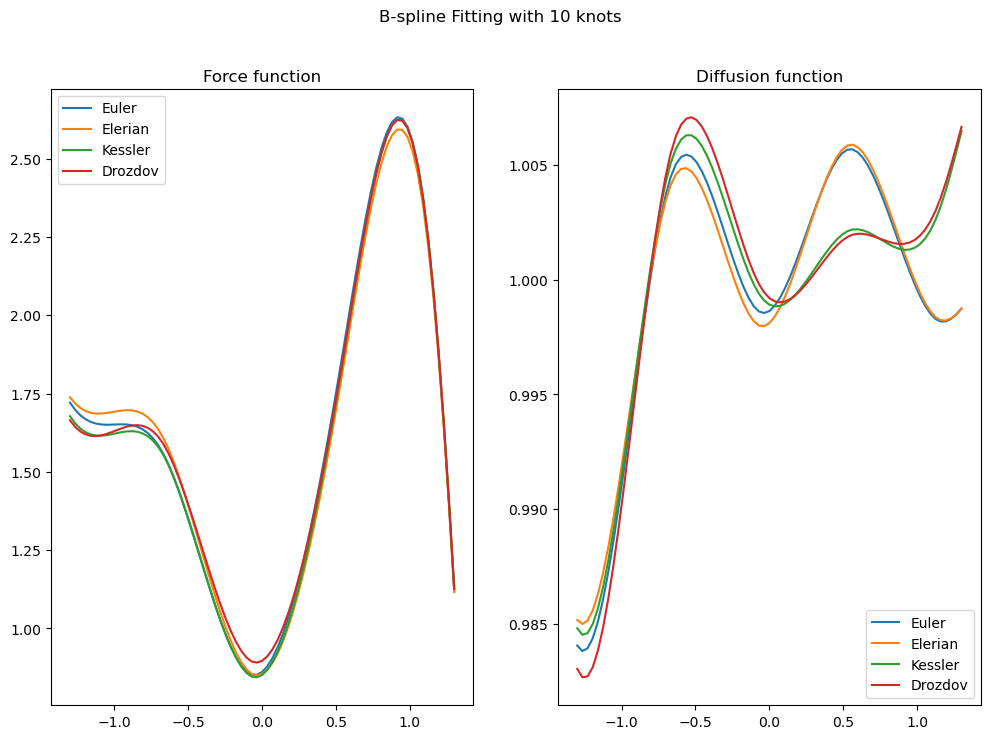

In [ ]:
n_knots=10
qfa = np.linspace(qdata.stats.min , qdata.stats.max,75)

domain = fl.MeshedDomain.create_from_range(np.linspace(min(qfa) , max(qfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(qdata)
Eln_res=Eln_estimator.fit_fetch(qdata)
Ksl_res=Ksl_estimator.fit_fetch(qdata)
Drz_res=Drz_estimator.fit_fetch(qdata)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    res.remove_bias()
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')


/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Model is not biased
Model is not biased
Model is not biased
Model is not biased


Text(0.5, 0.98, 'B-spline Fitting with 15 knots')

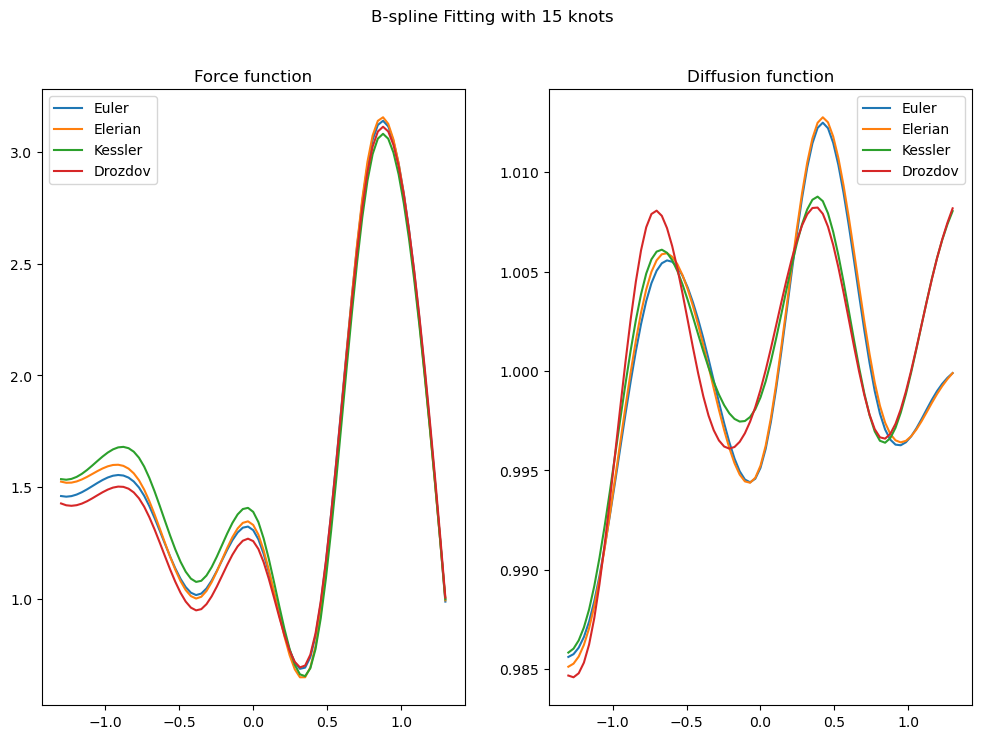

In [ ]:
n_knots=15
qfa = np.linspace(qdata.stats.min , qdata.stats.max,75)

domain = fl.MeshedDomain.create_from_range(np.linspace(min(qfa) , max(qfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(qdata)
Eln_res=Eln_estimator.fit_fetch(qdata)
Ksl_res=Ksl_estimator.fit_fetch(qdata)
Drz_res=Drz_estimator.fit_fetch(qdata)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    res.remove_bias()
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')

/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Model is not biased
Model is not biased
Model is not biased
Model is not biased


Text(0.5, 0.98, 'B-spline Fitting with 20 knots')

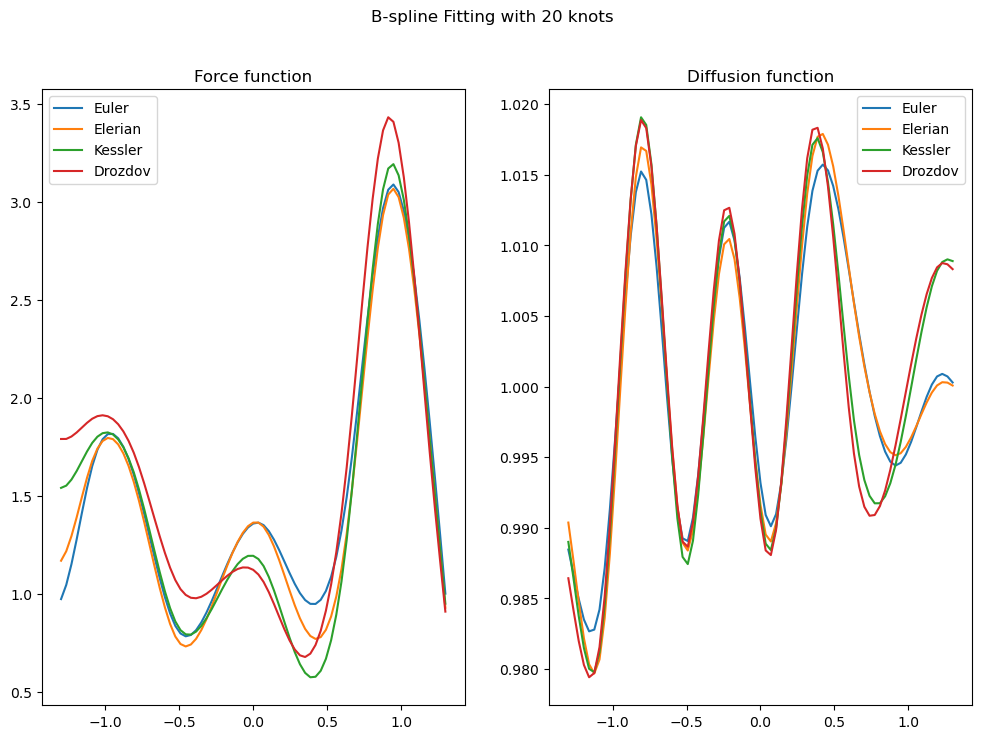

In [ ]:
n_knots=20
qfa = np.linspace(qdata.stats.min , qdata.stats.max,75)

domain = fl.MeshedDomain.create_from_range(np.linspace(min(qfa) , max(qfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(qdata)
Eln_res=Eln_estimator.fit_fetch(qdata)
Ksl_res=Ksl_estimator.fit_fetch(qdata)
Drz_res=Drz_estimator.fit_fetch(qdata)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    res.remove_bias()
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')

In [ ]:
qdata[0]

{'x': array([[-2.37990003],
        [-2.389089  ],
        [-2.37631397],
        ...,
        [ 1.71157814],
        [ 1.74038564],
        [ 1.74072826]]),
 'dt': 0.001,
 'bias': array([[ 0.        ],
        [ 0.        ],
        [ 0.12864563],
        ...,
        [-3.18881972],
        [-2.96209397],
        [-3.36539896]]),
 'xt': array([[-2.389089  ],
        [-2.37631397],
        [-2.42795759],
        ...,
        [ 1.74038564],
        [ 1.74072826],
        [ 1.76326094]])}

In [ ]:
zz= np.array([[1,2], [1,3], [0,-1]])
vv = np.array([1,1,1])
xx= np.dot(vv,zz)

In [ ]:
xdata[0]["bias"]-ydata[0]["bias"]

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
trj["x"][j]

array([1.07713689, 0.24002595])

In [ ]:
data[0]["x"]

array([[-1.20405468, -1.17584535],
       [-1.19221996, -1.19686904],
       [-1.16530066, -1.21101332],
       ...,
       [ 0.71488199,  1.02550365],
       [ 0.71131966,  1.0294086 ],
       [ 0.70982129,  1.05343965]])

attempt ornstein uhlembeck
==

sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape=

sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape= (25,)
sq_dt shape=

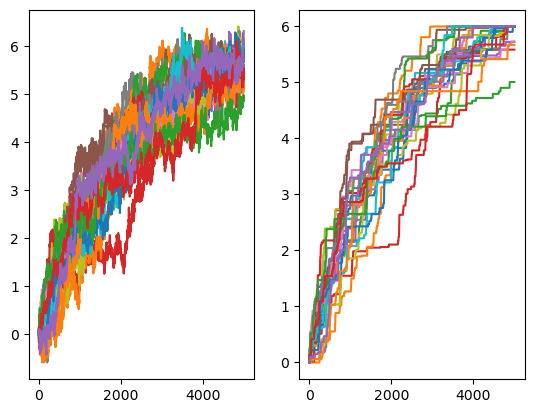

In [ ]:

model_simu = fl.models.OrnsteinUhlenbeck(0.0, 1.2, 2.0)
simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(model_simu), 1e-3, k=10.0, xstop=6.0)
data = simulator.run(5000, np.zeros((25,)), 1)
xmax = np.concatenate(simulator.xmax_hist, axis=1).T

# Plot the resulting trajectories
# sphinx_gallery_thumbnail_number = 1
fig, axs = plt.subplots(1, 2)
for n, trj in enumerate(data):
    axs[0].plot(trj["x"])
    axs[1].plot(xmax[:, n])

In [ ]:

# model_simu = fl.models.OrnsteinUhlenbeck(0.0, 1.2, 2.0)
# simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(model_simu), 1e-3, k=10.0, xstop=6.0)
# data = simulator.run(5000, np.zeros((25,)), 1)
# xmax = np.concatenate(simulator.xmax_hist, axis=1).T
# model_simu.remove_bias()
trainmodel=fl.models.OrnsteinUhlenbeck(has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modfications
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel))) # made by the previuos estimatorand so in the end they will return the exact same results
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # which is the reason why the loop checking if the values are different in the following cell exists
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


RecursionError: maximum recursion depth exceeded